In [1]:
import sys
sys.path.append('../')

import torch as tc
import numpy as np
import matplotlib.pyplot as plt

import gpytorch

from rcgp.experimental import SpatioTemporalRCGP
from rcgp.kernels import Matern32Kernel

from rcgp.weight_functions import IMQ, partial_y_IMQ

/opt/miniconda3/envs/RTGP/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
def generate_data(lengthscale=0.4, magnitude=2., var_y = 0.02, seed=42):
    tc.manual_seed(seed)  # For reproducibility

    x = tc.linspace(0, 1, 100)  # Same points for training and testing
    # Define known kernel parameters
    kernel = Matern32Kernel(lengthscale=tc.tensor(lengthscale), magnitude=tc.tensor(magnitude))

    cov_matrix = kernel.forward(x.reshape(-1,1), x.reshape(-1,1)) + 1e-5 * tc.eye(len(x))
    mean = tc.zeros(x.shape)

    true_f = tc.distributions.MultivariateNormal(mean, cov_matrix).sample()
    true_f = true_f - true_f.mean()

    noise = tc.distributions.Normal(0, var_y).sample(true_f.shape)

    y = true_f + noise

    return x, y, true_f

In [29]:
def rcgp(var_y, magnitude, lengthscale, grid, Ys, return_std=True):

    with tc.no_grad():
        matern_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=3/2))
        matern_kernel.base_kernel.lengthscale = tc.tensor(lengthscale)
        matern_kernel.outputscale = tc.tensor(magnitude)
        K = matern_kernel.forward(grid.reshape(-1,1), grid.reshape(-1,1))

    m = tc.zeros_like(Ys, dtype=tc.float32) + Ys.mean()

    beta= np.sqrt(var_y / 2)
    c= 1.
    
    w = IMQ(Y=Ys, m=m, beta=beta, c=c)
    partial_w = partial_y_IMQ(Y=Ys, m=m, beta=beta, c=c)

    J_w = tc.diag((var_y / 2) * w.flatten()**(-2))

    m_w = m + 2 * var_y * (w)**(-1) * partial_w

    A = tc.linalg.inv(K + var_y * J_w)

    mu_rcgp = m + K @ A @ (Ys - m_w)

    if return_std:
        Sigma = K @ A @ (var_y * J_w)
        std_rcgp = tc.sqrt(tc.diag(Sigma))
    
        return mu_rcgp.flatten(), std_rcgp

    else:
        return mu_rcgp.flatten()

In [65]:
def run(true_lengthscale=0.2, true_magnitude=2, true_var_y=0.25, seed=42):

    Xs, Ys, true_func = generate_data(lengthscale=true_lengthscale, magnitude=true_magnitude, var_y=true_var_y, seed=seed)

    st_rcgp = SpatioTemporalRCGP(ts=Xs.reshape(-1,1), grid=None, Ys=Ys.reshape(-1,1), p=1)

    st_rcgp.var_y = true_var_y
    st_rcgp.temporal_lengthscale = true_lengthscale
    st_rcgp.temporal_magnitude = true_magnitude

    with tc.no_grad():
        st_rcgp.activate_robustness(func='constant') #Weight function = Ys.mean()
        st_rcgp.c = 1. #Fixing c

        (pred_st_rcgp_robust, std_st_rcgp_robust, _), _, _  = st_rcgp.forward()
        pred_st_rcgp_robust = pred_st_rcgp_robust.squeeze()
        std_st_rcgp_robust = std_st_rcgp_robust.squeeze()

    pred_rcgp, std_rcgp = rcgp(var_y=true_var_y,
                            magnitude=true_magnitude,
                            lengthscale=true_lengthscale,
                            grid=Xs.reshape(-1,1),
                            Ys=Ys.reshape(-1,1))
    
    return (pred_st_rcgp_robust, std_st_rcgp_robust), (pred_rcgp, std_rcgp), Xs, Ys


def compare(true_lengthscale=0.2, true_magnitude=2, true_var_y=0.25, seed=42):
    (pred_st_rcgp_robust, std_st_rcgp_robust), (pred_rcgp, std_rcgp), Xs, Ys = run(true_lengthscale, true_magnitude, true_var_y, seed)

    return np.abs(pred_rcgp - pred_st_rcgp_robust).max(), np.abs(std_st_rcgp_robust - std_rcgp).max(), Ys


def plot(true_lengthscale=0.2, true_magnitude=2, true_var_y=0.25, seed=42):
    (pred_st_rcgp_robust, std_st_rcgp_robust), (pred_rcgp, std_rcgp), Xs, Ys = run(true_lengthscale, true_magnitude, true_var_y, seed)

    plt.figure(figsize=(6,3))

    #Data and True Function
    plt.plot(Xs.numpy(), Ys.numpy(), 'k.', label='Data')

    #ST-RCGP
    plt.plot(Xs.numpy(), pred_st_rcgp_robust.squeeze().numpy(), color='green', label='ST-RCGP')
    plt.fill_between(Xs.numpy(), pred_st_rcgp_robust.squeeze().numpy() - 3 * std_st_rcgp_robust.squeeze().numpy(), pred_st_rcgp_robust.squeeze().numpy() + 3 * std_st_rcgp_robust.squeeze().numpy(), color='green', alpha=0.3)

    #RCGP
    plt.plot(Xs.numpy(), pred_rcgp.squeeze().numpy(), color='red', label='RCGP')
    plt.fill_between(Xs.numpy(), pred_rcgp.squeeze().numpy() - 3 * std_rcgp.squeeze().numpy(), pred_rcgp.squeeze().numpy() + 3 * std_rcgp.squeeze().numpy(), color='red', alpha=0.3)

    plt.legend(fontsize=10)
    return
    

In [ ]:
lengthscale_vals = np.linspace(0.1, 3, 5)
magnitude_vals = np.linspace(1, 4, 5)
var_y_vals = np.linspace(0.1, 1, 5)

diff_means, diff_vars = [], []
for l in lengthscale_vals:
    for m in magnitude_vals:
        for var in var_y_vals:
            res = compare(l, m, var)
            diff_means.append(res[0])
            diff_vars.append(res[1])
            baselines.append(res[2].mean())

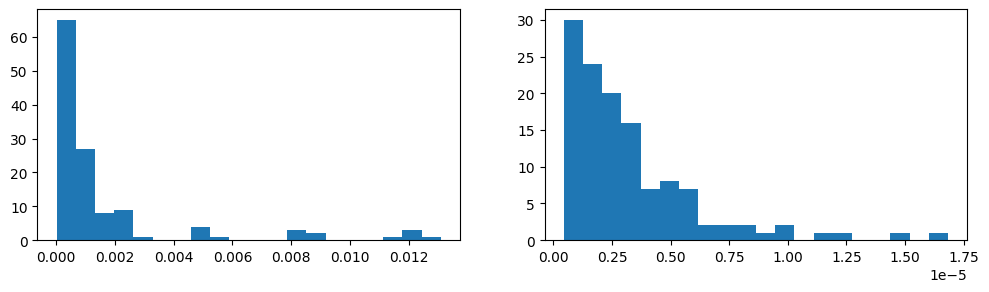

In [64]:
fig, axs = plt.subplots(1, 2, figsize=(12,3))
axs[0].hist(tc.stack(diff_means).numpy(), bins=20)
axs[1].hist(tc.stack(diff_vars).numpy(), bins=20);